In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from scipy.stats import cauchy
import matplotlib.pyplot as plt
import random

In [ ]:
#Loading new data set
# Looks at spy data from Yahoo
spy=pd.read_csv("stock_downloads/SPY.csv")
chipotle=pd.read_csv("stock_downloads/CMG.csv")
tesla=pd.read_csv("stock_downloads/TSLA.csv")
delta=pd.read_csv("stock_downloads/DAL.csv")
american=pd.read_csv("stock_downloads/AAL.csv")
coke=pd.read_csv("stock_downloads/KO.csv")
bitcoin=pd.read_csv("stock_downloads/BTC-USD.csv")
ethereum=pd.read_csv("stock_downloads/ETH-USD.csv")
apple=pd.read_csv("stock_downloads/AAPL.csv")
lyra=pd.read_csv("stock_downloads/LYRA.csv")
biocyrst=pd.read_csv("stock_downloads/BCRX.csv")
print(spy)

            Date        Open        High         Low       Close   Adj Close  \
0     2017-04-10  235.360001  236.259995  234.729996  235.339996  215.658493   
1     2017-04-11  234.899994  235.179993  233.339996  235.059998  215.401886   
2     2017-04-12  234.740005  234.960007  233.770004  234.029999  214.458038   
3     2017-04-13  233.639999  234.490005  232.509995  232.509995  213.065170   
4     2017-04-17  233.110001  234.570007  232.880005  234.570007  214.952911   
...          ...         ...         ...         ...         ...         ...   
1254  2022-04-01  453.309998  453.459991  449.140015  452.920013  452.920013   
1255  2022-04-04  453.130005  456.910004  452.260010  456.799988  456.799988   
1256  2022-04-05  455.220001  457.829987  449.820007  451.029999  451.029999   
1257  2022-04-06  446.890015  448.929993  443.470001  446.519989  446.519989   
1258  2022-04-07  445.589996  450.690002  443.529999  448.769989  448.769989   

         Volume  
0      67615300  
1  

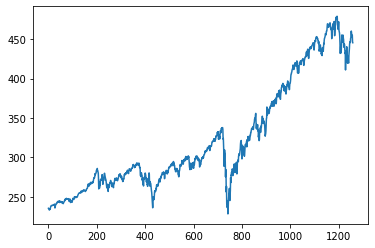

In [ ]:
#Loading the opening stock prices from spy data
free=spy["Open"].to_numpy()
plt.plot(free)

In [ ]:
#Creates a list that calculates the daily percent change of the stock
def growth_rate(free):
    diffs=[]
# just moves array over and makes percentage moves
    for i in range(len(free)-1):
        diffs.append(((free[i+1]-free[i])/free[i]))
    diffs=np.array(diffs)
    return diffs


In [ ]:
#Calculates mean daily growth based on a set number of previous days
def mean_func(diffs,prev_days):
    x=diffs[-prev_days:]
    return np.mean(x)

#Calculates standard deviation daily growht based on a set number of previous days
def std_func(diffs,prev_days):
    x=diffs[-prev_days:]
    return np.std(x)

In [ ]:
#Function that creates a 4x4 markov chain
def markov_chain(free,prev_days,std_fact,num_states):
    diffs=growth_rate(free)
    #Creates array only based on the number of days we want to look at
    #Std_fact is the number of standard deviations away from the mean that we define the states (i.e. 1 standard deviation away from the mean)
    adj_diffs=diffs[-prev_days:]
    mu = mean_func(adj_diffs,prev_days)
    std = std_func(adj_diffs,prev_days)
    #Creates 4x4 markov chain
    markov=np.zeros((num_states,num_states))
    #This array will be a count of the number of times past data entered each state
    count_array=np.zeros(num_states)
    #End will be an array of the growth of each of the past states to be used to find the mean of each of the past states
    end_array=np.zeros(num_states)
    #Initial State is the most recent state
    initial_state=0
    #Creates the counts for the states in the markov chain based on past data
    #Loops through the growth rate array
    #Starts at 1 since we look at previous data to determine the count
    for i in range(1,len(adj_diffs)):
        #Create variable to break out while loop
        ender_i=True
        #Variable to keep track of which row of the matrices we add the counts
        row=0
        #Start off the first state of while loop with a bound of less that -1 std below the mean
        std_bound_i=(-1.0*std_fact)
        #Outer while loop to decide what state previous day was in
        while ender_i:
            if (adj_diffs[i-1]<(mu+(std*std_bound_i))):
                #We add to the count and end arrays because these will be used to return means of each state
                count_array[row]+=1
                end_array[row]+=adj_diffs[i-1]
                ender_j=True
                column=0
                std_bound_j=(-1.0*std_fact)
                #Inner while loop to determine what state current day is in based on previous day
                while ender_j:
                    if (adj_diffs[i]<(mu+(std*std_bound_j))):
                        #Adding the day to the markov chain
                        markov[row][column]+=1
                        #This is to exit the inner while loop
                        ender_j=False
                    elif (adj_diffs[i]>(mu+(std*std_fact))):
                        #Adding the day to the markov chain
                        markov[row][num_states-1]+=1
                        #This is to exit the inner while loop
                        ender_j=False                        
                    else:
                        std_bound_j+=(std_fact/((num_states/2)-1))
                        column+=1     
                #This is to exit the outer while loop
                ender_i=False
            #Create elif scenerio to take into account case when state is greater than 1 std above mean
            elif (adj_diffs[i-1]>(mu+(std*std_fact))):
                #Last state in the matrix so must add 1 to the row index
                count_array[num_states-1]+=1
                end_array[num_states-1]+=adj_diffs[i-1]
                ender_j=True
                column=0
                std_bound_j=(-1.0*std_fact)
                #Inner while loop to determine what state current day is in based on previous day
                while ender_j:
                    if (adj_diffs[i]<(mu+(std*std_bound_j))):
                        #Adding the day to the markov chain
                        markov[num_states-1][column]+=1
                        #This is to exit the inner while loop
                        ender_j=False
                    elif (adj_diffs[i]>(mu+(std*std_fact))):
                        #Adding the day to the markov chain
                        markov[num_states-1][num_states-1]+=1
                        #This is to exit the inner while loop
                        ender_j=False                        
                    else:
                        std_bound_j+=(std_fact/((num_states/2)-1))
                        column+=1     
                #This is to exit the outer while loop
                ender_i=False               
            else:
                #We add this value to the std_bound because the fractions are based on the number of states implemented
                std_bound_i+=(std_fact/((num_states/2)-1))
                row+=1
        if adj_diffs[i]==adj_diffs[-1]:
            if (adj_diffs[i]>(mu+(std*std_fact))):
                initial_state=num_states-1
            else:
                initial_state=column
    #Adjusting for poisson rare events            
    for i in range(num_states):
        markov[i][0]=np.random.poisson(markov[i][0])
        markov[i][num_states-1]=np.random.poisson(markov[i][num_states-1])
    
    #Making sure there aren't rows with very few data
    for i in range(num_states):
        if np.max(markov[i])==0:
            for j in range(num_states):
                #Equal chance of passing into any of the other states
                markov[i][j]==1.0/num_states
    #Normalize the Markov Chain
    for i in range(num_states):
        sum_row=sum(markov[i])
        for j in range(num_states):
            markov[i][j]=(markov[i][j])/sum_row
    #Calculate the mean daily growth of past data from each state from the markov chain
    mu_array=np.zeros(num_states)
    for x in range(num_states):
        mu_array[x]=end_array[x]/count_array[x]
    return markov,mu,std,mu_array, initial_state
        

In [ ]:
#just added a return for the std and mu of the diffs
m,mu,std,mu_states,initial_state=markov_chain(free,1200,1,8)


In [ ]:
#change price just does the random sum with a poisson of 1 with the normal distribution of the mean and std entered
def change_price(stock,stock_change):
    mean,std=stock_change
    G=(sum(np.random.normal(mean,std,np.random.poisson(1))))
    # makes new prices and returns it
    diff=G*stock
    stock+=diff
    return stock
# selects state to walk through markov chain... code from one of the hws
def state_selector(array):
    point=random.random()
    Flag=True
    start=0
    hold=0
    new=point
    while Flag:
        new=new-array[start]
        if new > 0:
            start+=1
        else:
            return start

In [ ]:
# this is the main script... moves stocks price from the last stock price
def main_script(free,prev_days,std_fact,num_states,days_projected,visual=True):
    m,mu,std,mu_states,initial_state=markov_chain(free,prev_days,std_fact,num_states)
    #print(m,mu,std,mu_states,initial_state,days_projected)
    stock = free[-1]
    # intial cond
    #holder to get the values
    holder=[]
    stock_change=[mu,std]
    #Setting the states
    future=np.zeros((len(m),2))
    for i in range(len(m)):
        future[i][0]=mu_states[i]
        future[i][1]=std
    # moves and stores stock, makes a graph for reference 
    future_states=[]
    future_states.append(initial_state)
    for i in range(days_projected):
        state=state_selector(m[int(future_states[-1])])
        stock_change=future[state]
        stock=change_price(stock,stock_change)
        holder.append(stock)
        future_states.append(state)
    if visual:
        plt.plot(range(len(holder)),holder)
        plt.title(f"{name} Future Projections")
        plt.xlabel(f"Future Days")
        plt.ylabel("Stock Price")
        plt.show()
        plt.plot(range(-len(free),0),free)
        plt.title(f"{name} Past Data")
        plt.xlabel("Previous Days")
        plt.ylabel("Stock Price")
        plt.show()
        plt.scatter(range(len(holder)),holder,c=future_states[1:])
        plt.title(f"{name} Future Projections")
        plt.xlabel("Future Days")
        plt.ylabel("Stock Price")
        plt.show()
    return m,mu,std,mu_states,initial_state,days_projected,future,future_states,holder

In [51]:
def view_results(days_simulated,states,sim_times,initial_state,file_name="temp",output=True,std=1):
    days_tested=days_simulated
    mega=[]
    mega_states_list=[]
    for i in range(sim_times):
        future_states=[]
        future_states.append(initial_state)
        m_1,_,_,_,_,_,_,states_list,simulation=main_script(free,1200,std,states,days_tested,visual=False)
        mega_states_list.append(states_list)
        mega.append(simulation)
    dic={}
    for a,b in zip(mega,range(len(mega))):
        dic[str(b)]=a
    frame=pd.DataFrame(dic)
    data_frame=frame
    mean_for_all=((data_frame.iloc[-1]-data_frame.iloc[0])/data_frame.iloc[0])
    display(mean_for_all.describe())
    mean_for_all=mean_for_all/days_simulated
    tested=mean_for_all.mean()
    t_std=mean_for_all.std()
    temp=mega_states_list[0]
    for i in mega_states_list[1:]:
        temp=np.concatenate((temp,i))
    m,mu,std,mu_states,initial_state,days_projected,future,states_list,simulation=main_script(free,1200,1,8,1,visual=False)
    m,mu_little,std,mu_states,initial_state,days_projected,future,states_list,simulation=main_script(free,days_simulated,1,8,1,visual=False)
    plt.plot([mu,mu],[0,400],c="y",label="Real Data")
    plt.plot([tested,tested],[0,400],c="r",label="Simulated Data")
    plt.plot([tested+t_std,tested+t_std],[0,400],c="r",label="One Upper Std Sim Data")
    plt.plot([tested-t_std,tested-t_std],[0,400],c="r",label="One Lower Std Sim Data")
    plt.hist(mean_for_all,bins=100,density=True)
    plt.ylabel("Number of points")
    plt.title(f"{name} Histogram of returns")
    plt.xlabel("Mean return per day (percent)")
    plt.legend()
    if output:
        plt.savefig(f"Main_hist_{file_name}.jpg")
    plt.show()
    plt.ylabel("Number of times in State")
    plt.title(f"{name} Histogram of states")
    plt.xlabel("State Number")
    plt.hist(temp,density=True,bins=states)
    if output:
        plt.savefig(f"States_hist_{file_name}.jpg")
    plt.show()
    a=data_frame.T.describe().iloc[1].to_numpy()
    b=data_frame.T.describe().iloc[2].to_numpy()
    plt.plot(range(len(a)),a,label="Model mean")
    plt.plot(range(len(a)),a-b,label="Model lower std")
    plt.plot(range(len(a)),a+b,label="Model upper std")
    plt.plot([0,days_simulated],[free[-1],free[-1]+free[-1]*mu*days_simulated],label=f"Real {name} mean by average return")
    plt.plot([0,days_simulated],[free[-1],free[-1]+free[-1]*mu_little*days_simulated],label=f"Real {name} mean by return to day")
    plt.ylabel("Price")
    plt.title(f"{name} Future Projection")
    plt.xlabel("Number of days from start")
    plt.legend()
    if output:
        plt.savefig(f"Projection_plot_{file_name}.jpg")
    plt.show()
    a=generate_prob(mean_for_all,mu,tested,free,output,file_name)
    return a,m_1

def generate_prob(mean_for_all,mu,tested,free,output,file_name):
    n=tested-mu
    shift=(mean_for_all-n)
    diffs=growth_rate(free)
    plt.hist(diffs,bins=100,density=True)
    plt.ylabel("Number of times returned")
    plt.title(f"Real data {name} Histogram")
    plt.xlabel("Returns")
    plt.legend()
    if output:
        plt.savefig(f"Real_hist_{file_name}.jpg")
    plt.show()
    pos_prob=sum((shift>0))/len(shift)
    plt.hist(shift[shift>0],bins=100)
    plt.ylabel("Number of times returned")
    plt.title(f"Adjusted Positive Mass {name} Histogram")
    plt.xlabel("Adjusted Return")
    plt.legend()
    if output:
        plt.savefig(f"Positive_mass_{file_name}.jpg")
    plt.show()
    print(f"probability of positive return {pos_prob}")
    return pos_prob


In [ ]:
#test 
name="Bitcoin"
free=spy["Open"].to_numpy()
m,mu,std,mu_states,initial_state,days_projected,future,states_list,simulation=main_script(free,1200,1,8,days_tested,visual=True)
a,m=view_results(400,8,2000,initial_state)

In [ ]:
#test 
m,mu,std,mu_states,initial_state,days_projected,future,states_list,simulation=main_script(free,1200,1,8,days_tested,visual=True)
a,m=view_results(1200,8,2000,initial_state)

In [ ]:
temp={}
temp1={}
vary_states=[4,6,8,10]
name="Spy"
free=spy["Open"].to_numpy()
for i in vary_states:
    a,m=view_results(1200,i,2000,initial_state,output=True,file_name=f"v_states_{i}")
    temp[f"v_states_prob_{i}"]=[a]
    temp1[f"v_states_matrix_{i}"]=m

In [83]:
temp1['v_states_matrix_4']

array([[0.17886179, 0.19512195, 0.40650407, 0.2195122 ],
       [0.09174312, 0.3646789 , 0.46100917, 0.08256881],
       [0.07393715, 0.39926063, 0.45101664, 0.07578558],
       [0.18867925, 0.26415094, 0.4245283 , 0.12264151]])

In [ ]:
temp={}
temp1={}
vary_std=[.25,.5,1,2]
for i in vary_std:
    a,m=view_results(1200,8,2000,initial_state,std=i,output=True,file_name=f"v_std_{i}")
    temp[f"v_stds_prob_{i}"]=[a]
    temp1[f"v_stds_matrix_{i}"]=m
pd.DataFrame(temp).to_json("vary_stds.json")

In [ ]:
stock_list=[spy,
chipotle,
tesla,
delta,
american,
coke,
bitcoin,
ethereum,
apple,
#lyra,
biocyrst]
namess=["Spy",
"Chipotle",
"Tesla",
"Delta",
"American",
"Coke",
"Bitcoin",
"Ethereum",
"Apple",
#"lyra",
"Biocyrst"]
temp={}
temp1={}
for i,b in zip(stock_list,namess):
    name=b
    free=i["Open"].to_numpy()
    m,mu,std,mu_states,initial_state,days_projected,future,states_list,simulation=main_script(free,1200,1,8,days_tested,visual=True)
    a,m=view_results(1200,8,2000,initial_state,output=True,file_name=f"v_stocks_{name}")
    temp[f"v_stocks_prob_{name}"]=[a]
    temp1[f"v_stocks_matrix_{name}"]=m
pd.DataFrame(temp).to_json("vary_stocks.json")

In [95]:
temp

{'v_stocks_prob_Spy': [0.5925],
 'v_stocks_prob_Chipotle': [0.289],
 'v_stocks_prob_Tesla': [0.0905],
 'v_stocks_prob_Delta': [0.1705],
 'v_stocks_prob_American': [0.0985],
 'v_stocks_prob_Coke': [0.4965],
 'v_stocks_prob_Bitcoin': [0.128],
 'v_stocks_prob_Ethereum': [0.063],
 'v_stocks_prob_Apple': [0.359],
 'v_stocks_prob_Biocyrst': [0.0865]}

count    2000.000000
mean        0.119777
std         0.304686
min        -0.564257
25%        -0.100012
50%         0.077686
75%         0.291403
max         1.588440
dtype: float64

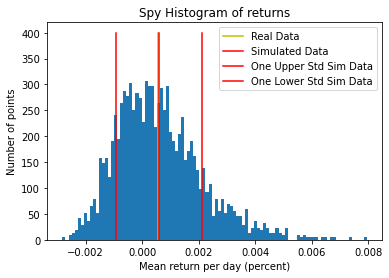

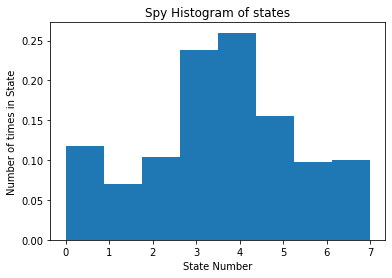

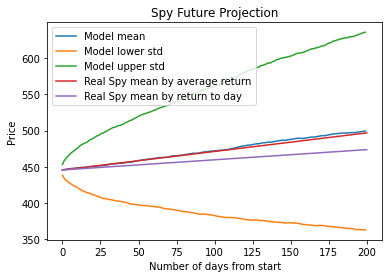

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


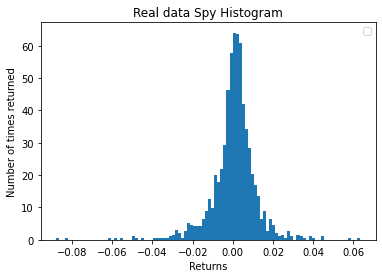

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


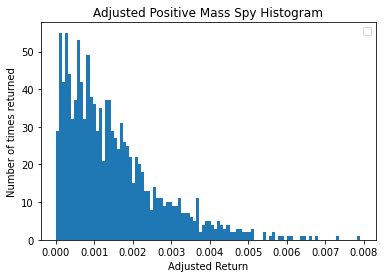

probability of positive return 0.603


count    2000.000000
mean        0.262756
std         0.510560
min        -0.694254
25%        -0.102257
50%         0.177447
75%         0.533394
max         3.943676
dtype: float64

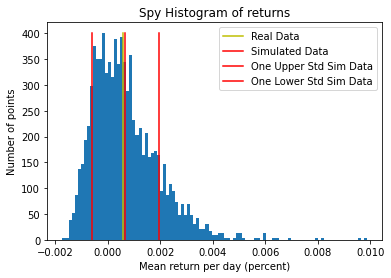

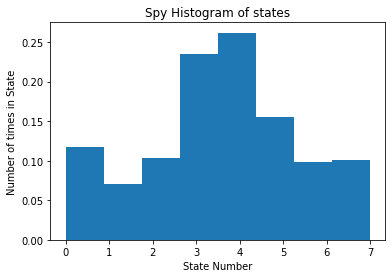

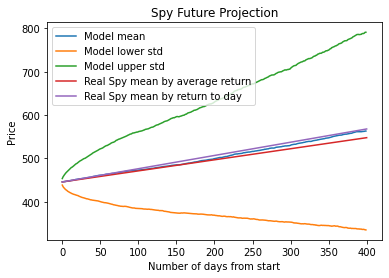

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


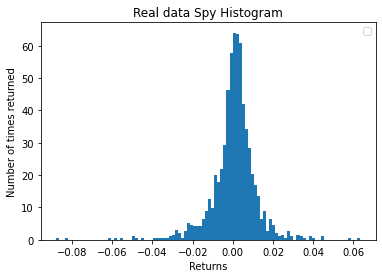

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


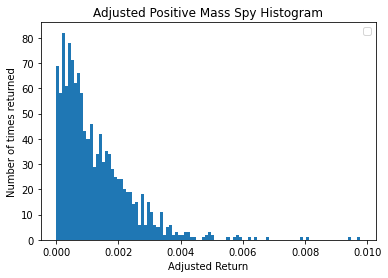

probability of positive return 0.6275


count    2000.000000
mean        0.608407
std         1.003744
min        -0.761526
25%        -0.057874
50%         0.376130
75%         1.006163
max        11.850474
dtype: float64

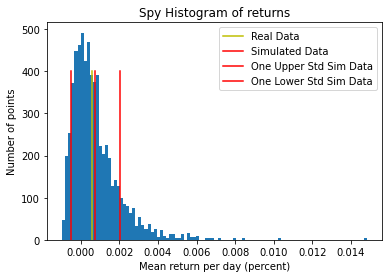

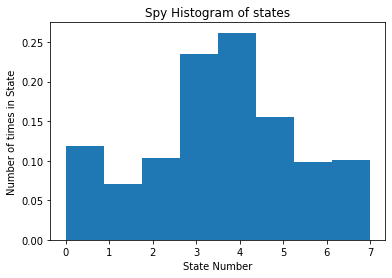

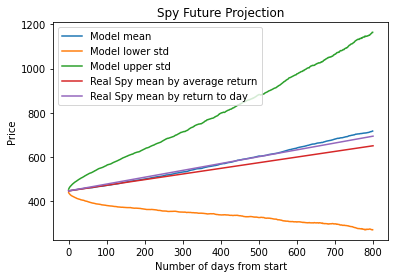

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


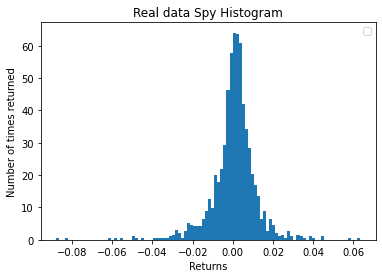

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


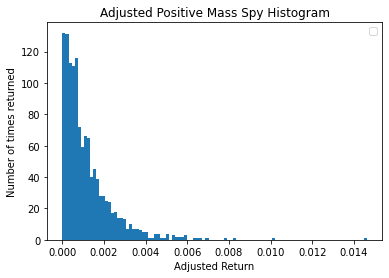

probability of positive return 0.6265


count    2000.000000
mean        1.069453
std         1.795499
min        -0.900504
25%        -0.003969
50%         0.607908
75%         1.594870
max        22.800219
dtype: float64

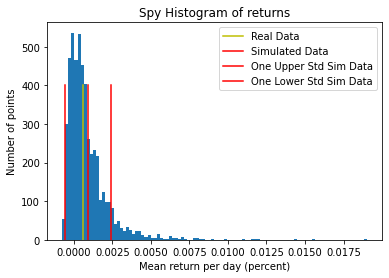

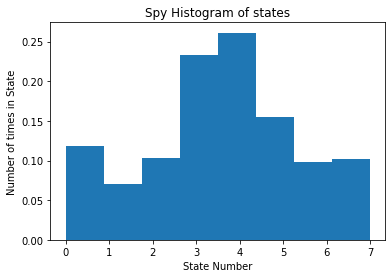

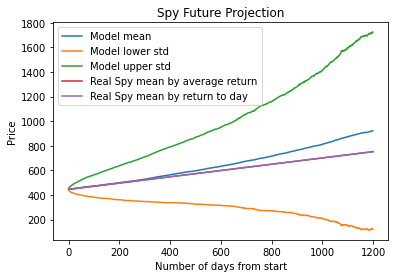

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


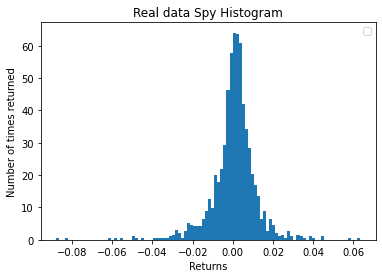

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


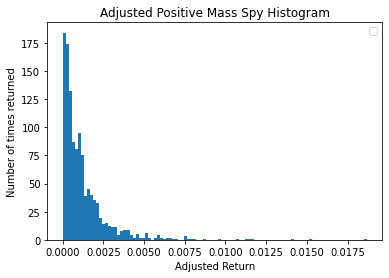

probability of positive return 0.5925


In [97]:
temp={}
temp1={}
vary_std=[200,400,800,1200]
name="Spy"
free=spy["Open"].to_numpy()
for i in vary_std:
    a,m=view_results(i,8,2000,initial_state,std=1,output=True,file_name=f"v_n_states_{i}")
    temp[f"v_n_states_prob_{i}"]=[a]
    temp1[f"v_n_states_matrix_{i}"]=m
pd.DataFrame(temp).to_json("v_n_states{i}.json")

In [98]:
temp

{'v_n_states_prob_200': [0.603],
 'v_n_states_prob_400': [0.6275],
 'v_n_states_prob_800': [0.6265],
 'v_n_states_prob_1200': [0.5925]}